In [1]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.optimizers import Adam

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\sarab\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
toxic_comments = pd.read_csv("D:/sabudh/datasets/toxic comments/train.csv")

In [3]:
print(toxic_comments.shape)

(159571, 8)


In [4]:
filter = toxic_comments["comment_text"] != ""
toxic_comments = toxic_comments[filter]
toxic_comments = toxic_comments.dropna()

In [5]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [6]:
X = []
sentences = list(toxic_comments["comment_text"])
for sen in sentences:
    X.append(preprocess_text(sen))

In [7]:
toxic = np.sum(toxic_comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]],axis = 1) > 0

In [8]:
from nltk.corpus import stopwords

In [9]:
my_stopwords = stopwords.words('english')

In [10]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('D:/Teaching/ISB/data/glove/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

### Vectorize the comments

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words = my_stopwords)
bag_of_words = vectorizer.fit_transform(X)

In [12]:
4350253/(159571*168645)*100

0.016165423205353118

In [13]:
bag_of_words

<159571x168645 sparse matrix of type '<class 'numpy.float64'>'
	with 4350253 stored elements in Compressed Sparse Row format>

In [14]:
list(vectorizer.vocabulary_.keys())

['explanation',
 'edits',
 'made',
 'username',
 'hardcore',
 'metallica',
 'fan',
 'reverted',
 'vandalisms',
 'closure',
 'gas',
 'voted',
 'new',
 'york',
 'dolls',
 'fac',
 'please',
 'remove',
 'template',
 'talk',
 'page',
 'since',
 'retired',
 'aww',
 'matches',
 'background',
 'colour',
 'seemingly',
 'stuck',
 'thanks',
 'january',
 'utc',
 'hey',
 'man',
 'really',
 'trying',
 'edit',
 'war',
 'guy',
 'constantly',
 'removing',
 'relevant',
 'information',
 'talking',
 'instead',
 'seems',
 'care',
 'formatting',
 'actual',
 'info',
 'make',
 'real',
 'suggestions',
 'improvement',
 'wondered',
 'section',
 'statistics',
 'later',
 'subsection',
 'types',
 'accidents',
 'think',
 'references',
 'may',
 'need',
 'tidying',
 'exact',
 'format',
 'ie',
 'date',
 'etc',
 'one',
 'else',
 'first',
 'preferences',
 'style',
 'want',
 'let',
 'know',
 'appears',
 'backlog',
 'articles',
 'review',
 'guess',
 'delay',
 'reviewer',
 'turns',
 'listed',
 'form',
 'eg',
 'wikipedia',
 

In [15]:
len(list(vectorizer.vocabulary_.keys()))

168645

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words = my_stopwords)
bag_of_words = vectorizer.fit_transform(X)

In [17]:
print(bag_of_words.shape, len(vectorizer.vocabulary_))

(159571, 168645) 168645


In [18]:
embeds = []
zeros_embed = 100*[0]
for key,val in sorted(vectorizer.vocabulary_.items(), key = lambda kv:(kv[1], kv[0])):
# vectorizer.vocabulary_.keys():
    if key in embeddings_dictionary:
        embeds.append(embeddings_dictionary[key])
    else:
        embeds.append(zeros_embed)
    if val%1000 == 0:
        print(val,key)


0 aa
1000 accorta
2000 adminnaizsi
3000 aggrevation
4000 albo
5000 altor
6000 andjapan
7000 antiquary
8000 aquainted
9000 arrogans
10000 associazioni
11000 austrolestes
12000 baceline
13000 bannock
14000 bd
15000 benegiciary
16000 bidhonene
17000 blakey
18000 boilers
19000 bpm
20000 bronze
21000 burgnich
22000 calvary
23000 carpelan
24000 ceirtain
25000 charge
26000 chlorophyta
27000 civillist
28000 coauthor
29000 commeneced
30000 coneheads
31000 contflict
32000 correspondant
33000 creb
34000 cudnt
35000 dainomite
36000 deadend
37000 delamarche
38000 derrier
39000 dialectal
40000 diry
41000 distant
42000 donkeykong
43000 drowning
44000 eachothers
45000 egad
46000 emaneuel
47000 enigmasoldier
48000 ern
49000 euwe
50000 experimental
51000 falcionek
52000 feckless
53000 finalist
54000 flunk
55000 fozzy
56000 ftrl
57000 gallium
58000 generated
59000 gilliam
60000 golat
61000 gratim
62000 guidelinesthe
63000 halab
64000 harvested
65000 helicopterllama
66000 hiineedrequestforcomment
67000 ho

In [19]:
import scipy.sparse as sparse
my_embeddings = sparse.csr_matrix(embeds)

In [20]:
doc_embeds = bag_of_words.dot(my_embeddings)

In [21]:
doc_embeds.shape

(159571, 100)

In [22]:
X_train_de, X_test_de, y_train_de, y_test_de = train_test_split(doc_embeds, toxic, test_size=0.20, random_state=42)

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import plot_roc_curve

In [24]:
lr = LogisticRegression()
dt = DecisionTreeClassifier(max_depth=25)
rf = RandomForestClassifier(max_depth=15, n_estimators=40)
# clf = SVC(kernel='linear',gamma='auto',degree=2)

In [25]:
lr.fit(X_train_de,y_train_de)
dt.fit(X_train_de,y_train_de)
rf.fit(X_train_de,y_train_de)
# clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

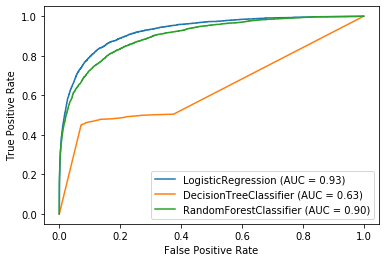

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
disp = plot_roc_curve(lr,X_test_de,y_test_de)
plot_roc_curve(dt,X_test_de,y_test_de,ax=disp.ax_)
plot_roc_curve(rf,X_test_de,y_test_de,ax=disp.ax_)
# plot_roc_curve(clf,X_test,y_test,ax=disp.ax_)

In [27]:
from keras import regularizers
maxlen=100
l1_thres = 1e-4
l2_thres = 1e-5
deep_inputs = Input(shape=(maxlen,))
dense_layer_1 = Dense(128, activation='tanh',kernel_regularizer=regularizers.l1_l2(l1=l1_thres, l2=l2_thres))(deep_inputs)
dense_layer_2 = Dense(64, activation='tanh',kernel_regularizer=regularizers.l1_l2(l1=l1_thres, l2=l2_thres))(dense_layer_1)
dense_layer_3 = Dense(32, activation='tanh',kernel_regularizer=regularizers.l1_l2(l1=l1_thres, l2=l2_thres))(dense_layer_2)
dense_layer_4 = Dense(16, activation='tanh',kernel_regularizer=regularizers.l1_l2(l1=l1_thres, l2=l2_thres))(dense_layer_3)
dense_layer_5 = Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l1_l2(l1=l1_thres, l2=l2_thres))(dense_layer_4)
model = Model(inputs=deep_inputs, outputs=dense_layer_5)
opt = Adam()
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [28]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 23,809
Trainable params: 23,809
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
X_res = X_train_de
y_res = y_train_de
# ros = RandomOverSampler(random_state=42)
# X_res, y_res = ros.fit_resample(X_train, y_train)
# sm = SMOTE(random_state=42)
# X_res, y_res = sm.fit_resample(X_train, y_train)

In [30]:
history = model.fit(X_res, y_res, batch_size=256, epochs=50, verbose=1, validation_split=0.2)


Train on 102124 samples, validate on 25532 samples
Epoch 1/50
102124/102124 [==============================] - 2s 24us/step - loss: 0.3730 - acc: 0.9262 - val_loss: 0.3112 - val_acc: 0.9375
Epoch 2/50
102124/102124 [==============================] - 2s 17us/step - loss: 0.2861 - acc: 0.9349 - val_loss: 0.2621 - val_acc: 0.9378
Epoch 3/50
102124/102124 [==============================] - 2s 17us/step - loss: 0.2471 - acc: 0.9363 - val_loss: 0.2363 - val_acc: 0.9367
Epoch 4/50
102124/102124 [==============================] - 2s 16us/step - loss: 0.2249 - acc: 0.9358 - val_loss: 0.2167 - val_acc: 0.9381
Epoch 5/50
102124/102124 [==============================] - 2s 17us/step - loss: 0.2109 - acc: 0.9361 - val_loss: 0.2037 - val_acc: 0.9384
Epoch 6/50
102124/102124 [==============================] - 2s 18us/step - loss: 0.2012 - acc: 0.9368 - val_loss: 0.1961 - val_acc: 0.9396
Epoch 7/50
102124/102124 [==============================] - 2s 18us/step - loss: 0.1942 - acc: 0.9370 - val_loss: 

In [31]:
from keras.engine.training import Model
def conf(my_model,thres,test_data,test_y):
    if isinstance(my_model, Model):
        output = my_model.predict(test_data)
    else:
        output = my_model.predict_proba(test_data)[:,list(my_model.classes_).index(True)]
    pred = (output>thres)
    from sklearn.metrics import confusion_matrix
    return confusion_matrix(test_y, pred)

In [32]:
conf(model,0.5,X_test_de,y_test_de)

array([[28266,   405],
       [ 1489,  1755]], dtype=int64)

In [33]:
conf(lr,0.5,X_test_de,y_test_de)

array([[28218,   453],
       [ 1669,  1575]], dtype=int64)

In [34]:
conf(dt,0.5,X_test_de,y_test_de)

array([[26618,  2053],
       [ 1791,  1453]], dtype=int64)

In [35]:
conf(rf,0.5,X_test_de,y_test_de)

array([[28524,   147],
       [ 2147,  1097]], dtype=int64)

In [36]:
import matplotlib.pyplot as plt
def plot_training_data(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])

    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])

    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

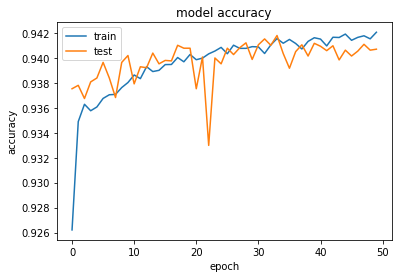

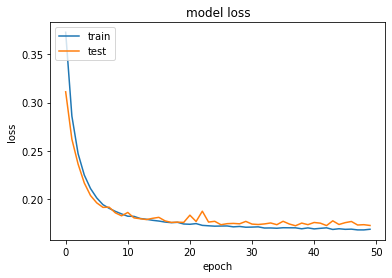

In [37]:
plot_training_data(history)

### LSTM Based Model

In [38]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, toxic, test_size=0.20, random_state=42)

In [40]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [41]:
tokenizer.word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'and': 4,
 'you': 5,
 'is': 6,
 'that': 7,
 'it': 8,
 'in': 9,
 'for': 10,
 'this': 11,
 'not': 12,
 'on': 13,
 'be': 14,
 'as': 15,
 'have': 16,
 'are': 17,
 'your': 18,
 'with': 19,
 'if': 20,
 'article': 21,
 'was': 22,
 'or': 23,
 'but': 24,
 'wikipedia': 25,
 'page': 26,
 'my': 27,
 'an': 28,
 'from': 29,
 'by': 30,
 'do': 31,
 'at': 32,
 'can': 33,
 'talk': 34,
 'me': 35,
 'about': 36,
 'so': 37,
 'what': 38,
 'there': 39,
 'all': 40,
 'has': 41,
 'will': 42,
 'please': 43,
 'one': 44,
 'would': 45,
 'no': 46,
 'they': 47,
 'he': 48,
 'like': 49,
 'just': 50,
 'we': 51,
 'which': 52,
 'any': 53,
 'been': 54,
 'should': 55,
 'don': 56,
 'more': 57,
 'some': 58,
 'other': 59,
 'who': 60,
 'here': 61,
 'see': 62,
 'also': 63,
 'his': 64,
 'think': 65,
 'know': 66,
 'because': 67,
 'am': 68,
 'how': 69,
 'people': 70,
 'edit': 71,
 'up': 72,
 'm': 73,
 'why': 74,
 'only': 75,
 'out': 76,
 'articles': 77,
 'use': 78,
 'when': 79,
 'then': 80,
 'time': 8

In [42]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

#### Using Glove Vectors

In [43]:
from keras import regularizers
k1_thres = 1e-5
k2_thres = 1e-5
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(256,kernel_regularizer=regularizers.l1_l2(l1=k1_thres, l2=k2_thres))(embedding_layer)
dense_layer_1 = Dense(128, activation='sigmoid',kernel_regularizer=regularizers.l1_l2(l1=k1_thres, l2=k2_thres))(LSTM_Layer_1)
dense_layer_2 = Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l1_l2(l1=k1_thres, l2=k2_thres))(dense_layer_1)
model_lstm_trans_reg = Model(inputs=deep_inputs, outputs=dense_layer_2)
opt = Adam()
model_lstm_trans_reg.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

In [44]:
print(model_lstm_trans_reg.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          14824300  
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 15,222,893
Trainable params: 398,593
Non-trainable params: 14,824,300
_________________________________________________________________
None


In [45]:
from keras.utils import plot_model
plot_model(model_lstm_trans_reg, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [46]:
history = model_lstm_trans_reg.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/20
102124/102124 [==============================] - 1661s 16ms/step - loss: 0.3338 - acc: 0.9004 - val_loss: 0.3236 - val_acc: 0.9018
Epoch 2/20
102124/102124 [==============================] - 1563s 15ms/step - loss: 0.3250 - acc: 0.8986 - val_loss: 0.3055 - val_acc: 0.8979
Epoch 3/20
102124/102124 [==============================] - 1309s 13ms/step - loss: 0.3040 - acc: 0.8984 - val_loss: 0.3014 - val_acc: 0.8979
Epoch 4/20
102124/102124 [==============================] - 1170s 11ms/step - loss: 0.3309 - acc: 0.8984 - val_loss: 0.3396 - val_acc: 0.8979
Epoch 5/20
102124/102124 [==============================] - 1183s 12ms/step - loss: 0.2823 - acc: 0.9089 - val_loss: 0.1759 - val_acc: 0.9421
Epoch 6/20
102124/102124 [==============================] - 1077s 11ms/step - loss: 0.1715 - acc: 0.9460 - val_loss: 0.1493 - val_acc: 0.9528
Epoch 7/20
102124/102124 [==============================] - 1037s 10ms/step - loss: 0.1504 - acc:

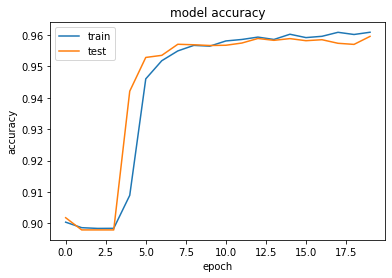

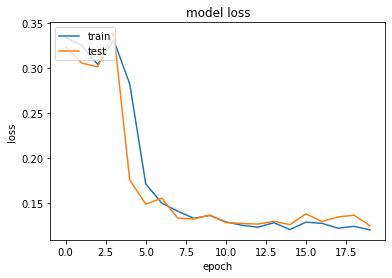

In [47]:
plot_training_data(history)

### Using Tunable Glove Vectors

In [252]:
from keras import regularizers

deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=True)(deep_inputs)
LSTM_Layer_1 = LSTM(256)(embedding_layer)
dense_layer_1 = Dense(128, activation='sigmoid')(LSTM_Layer_1)
dense_layer_2 = Dense(1, activation='sigmoid')(dense_layer_1)
model_lstm_trans_tune = Model(inputs=deep_inputs, outputs=dense_layer_2)
opt = Adam()
model_lstm_trans_tune.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

In [253]:
print(model_lstm_trans_tune.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 200)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 200, 100)          14824300  
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_85 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_86 (Dense)             (None, 1)                 129       
Total params: 15,222,893
Trainable params: 15,222,893
Non-trainable params: 0
_________________________________________________________________
None


In [254]:
from keras.utils import plot_model
plot_model(model_lstm_trans_tune, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [256]:
history = model_lstm_trans_tune.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/20
102124/102124 [==============================] - 1824s 18ms/step - loss: 0.2828 - acc: 0.9058 - val_loss: 0.2419 - val_acc: 0.9243
Epoch 2/20
102124/102124 [==============================] - 1817s 18ms/step - loss: 0.2970 - acc: 0.8993 - val_loss: 0.3268 - val_acc: 0.8979
Epoch 3/20
102124/102124 [==============================] - 1839s 18ms/step - loss: 0.2187 - acc: 0.9336 - val_loss: 0.1488 - val_acc: 0.9562
Epoch 4/20
102124/102124 [==============================] - 1861s 18ms/step - loss: 0.1251 - acc: 0.9599 - val_loss: 0.1184 - val_acc: 0.9604
Epoch 5/20
102124/102124 [==============================] - 2018s 20ms/step - loss: 0.1084 - acc: 0.9637 - val_loss: 0.1138 - val_acc: 0.9606
Epoch 6/20
102124/102124 [==============================] - 2324s 23ms/step - loss: 0.0994 - acc: 0.9668 - val_loss: 0.1115 - val_acc: 0.9611
Epoch 7/20
102124/102124 [==============================] - 2263s 22ms/step - loss: 0.0917 - acc:

In [399]:
vec = 105
my_emb = model_lstm_trans_tune.layers[1].get_weights()[0][vec,:]
len = my_emb.dot(my_emb)
print(len)

40.10566


In [400]:
orig_emb = embedding_matrix[vec,:]
len1 = orig_emb.dot(orig_emb)
print(len1)

32.58092743612775


In [401]:
import math
my_emb.dot(orig_emb)/(math.sqrt(len)*math.sqrt(len1))

0.9566419404132904

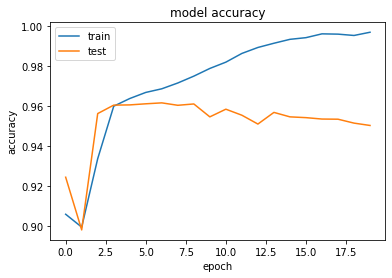

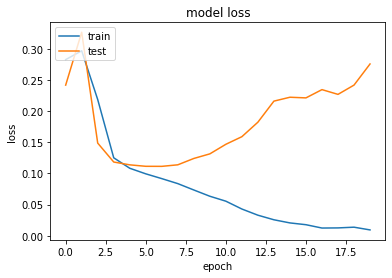

In [258]:
plot_training_data(history)

### Tuning Embedding from Scratch


In [270]:
from keras import regularizers
#kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-5)
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100)(deep_inputs)
LSTM_Layer_1 = LSTM(256,kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-5))(embedding_layer)
dense_layer_1 = Dense(128, activation='sigmoid',kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-5))(LSTM_Layer_1)
dense_layer_2 = Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-5))(dense_layer_1)
model_lstm_tune = Model(inputs=deep_inputs, outputs=dense_layer_2)
opt = Adam()
model_lstm_tune.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

In [271]:
history = model_lstm_tune.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/20
102124/102124 [==============================] - 1802s 18ms/step - loss: 0.3316 - acc: 0.8999 - val_loss: 0.3194 - val_acc: 0.9031
Epoch 2/20
102124/102124 [==============================] - 1844s 18ms/step - loss: 0.2970 - acc: 0.9102 - val_loss: 0.2730 - val_acc: 0.9170
Epoch 3/20
102124/102124 [==============================] - 1846s 18ms/step - loss: 0.2773 - acc: 0.9134 - val_loss: 0.3348 - val_acc: 0.8979
Epoch 4/20
102124/102124 [==============================] - 1854s 18ms/step - loss: 0.2973 - acc: 0.9063 - val_loss: 0.3308 - val_acc: 0.8979
Epoch 5/20
102124/102124 [==============================] - 1831s 18ms/step - loss: 0.3116 - acc: 0.9065 - val_loss: 0.2905 - val_acc: 0.9154
Epoch 6/20
102124/102124 [==============================] - 1833s 18ms/step - loss: 0.2874 - acc: 0.9162 - val_loss: 0.2811 - val_acc: 0.9193
Epoch 7/20
102124/102124 [==============================] - 1845s 18ms/step - loss: 0.2847 - acc:

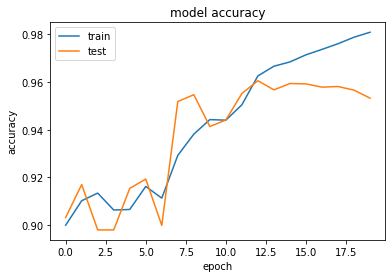

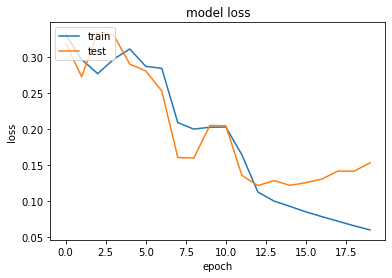

In [272]:
plot_training_data(history)

#### Out of Vocabulary training

### Evaluation of Models

In [52]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(X_test_de).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_de, y_pred_keras)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [62]:
y_pred_lstm_trans = model_lstm_trans.predict(X_test).ravel()
fpr_lstm_trans, tpr_lstm_trans, thresholds_lstm_trans = roc_curve(y_test, y_pred_lstm_trans)
auc_lstm_trans = auc(fpr_lstm_trans, tpr_lstm_trans)

In [63]:
y_pred_lstm_trans_reg = model_lstm_trans_reg.predict(X_test).ravel()
fpr_lstm_trans_reg, tpr_lstm_trans_reg, thresholds_lstm_trans_reg = roc_curve(y_test, y_pred_lstm_trans_reg)
auc_lstm_trans_reg = auc(fpr_lstm_trans_reg, tpr_lstm_trans_reg)

In [64]:
y_pred_lstm_trans_tune = model_lstm_trans_tune.predict(X_test).ravel()
fpr_lstm_trans_tune, tpr_lstm_trans_tune, thresholds_lstm_trans_tune = roc_curve(y_test, y_pred_lstm_trans_tune)
auc_lstm_trans_tune = auc(fpr_lstm_trans_tune, tpr_lstm_trans_tune)

In [65]:
y_pred_lstm_tune = model_lstm_tune.predict(X_test).ravel()
fpr_lstm_tune, tpr_lstm_tune, thresholds_lstm_tune = roc_curve(y_test, y_pred_lstm_tune)
auc_lstm_tune = auc(fpr_lstm_tune, tpr_lstm_tune)

In [67]:
# from sklearn.ensemble import RandomForestClassifier
# # Supervised transformation based on random forests
# rf = RandomForestClassifier(max_depth=5, n_estimators=10)
# rf.fit(X_train, y_train)

y_pred_dt = dt.predict_proba(X_test_de)[:, 1]
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test_de, y_pred_dt)
auc_dt = auc(fpr_dt, tpr_dt)

y_pred_rf = rf.predict_proba(X_test_de)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test_de, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

In [68]:
y_pred_lr = lr.predict_proba(X_test_de)[:, 1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test_de, y_pred_lr)
auc_lr = auc(fpr_lr, tpr_lr)

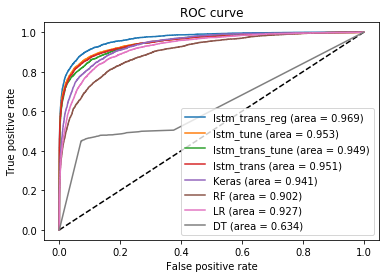

In [75]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lstm_trans_reg, tpr_lstm_trans_reg, label='lstm_trans_reg (area = {:.3f})'.format(auc_lstm_trans_reg))
plt.plot(fpr_lstm_tune, tpr_lstm_tune, label='lstm_tune (area = {:.3f})'.format(auc_lstm_tune))
plt.plot(fpr_lstm_trans_tune, tpr_lstm_trans_tune, label='lstm_trans_tune (area = {:.3f})'.format(auc_lstm_trans_tune))
plt.plot(fpr_lstm_trans, tpr_lstm_trans, label='lstm_trans (area = {:.3f})'.format(auc_lstm_trans))
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.plot(fpr_lr, tpr_lr, label='LR (area = {:.3f})'.format(auc_lr))
plt.plot(fpr_dt, tpr_dt, label='DT (area = {:.3f})'.format(auc_dt))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
# plt.figure(2)
# plt.xlim(0, 0.2)
# plt.ylim(0.8, 1)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('ROC curve (zoomed in at top left)')
# plt.legend(loc='best')
# plt.show()

In [76]:
conf(model_lstm_trans_reg,0.2,X_test,y_test)

array([[27422,  1249],
       [  527,  2717]], dtype=int64)

In [449]:
model.save("model_dann.h5")
print("Saved model to disk")

Saved model to disk


In [61]:
from keras.models import load_model
model_lstm_trans = load_model('model_lstm_trans.h5')
# summarize model.
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        (None, 200)               0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 200, 100)          14824300  
_________________________________________________________________
lstm_7 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_89 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_90 (Dense)             (None, 1)                 129       
Total params: 15,222,893
Trainable params: 15,222,893
Non-trainable params: 0
_________________________________________________________________


In [454]:
model_lstm_trans.save("model_lstm_trans.h5")
print("Saved model to disk")

Saved model to disk


In [70]:
model_lstm_trans_reg.save("model_lstm_trans_reg.h5")
print("Saved model to disk")

Saved model to disk


In [456]:
model_lstm_trans_tune.save("model_lstm_trans_tune.h5")
print("Saved model to disk")

Saved model to disk


In [457]:
model_lstm_tune.save("model_lstm_tune.h5")
print("Saved model to disk")

Saved model to disk


### Attempt to increase matches by lemmatizing

In [ ]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() 
missing_count=0
missing_words=[]
for key in vectorizer.vocabulary_.keys():
    if key not in embeddings_dictionary.keys():
        if lemmatizer.lemmatize(key) not in embeddings_dictionary.keys():
            missing_count = missing_count+1
            missing_words.append(key)
print(missing_count)

### Attempt to do LSH to find spelling mistakes

In [ ]:
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
mykeys = []
for key in embeddings_dictionary.keys():
    mykeys.append(preprocess_text(key))

vec = HashingVectorizer(analyzer='char',ngram_range=(1,4),norm='l2')
char_strings = vec.fit_transform(mykeys)

In [ ]:
# data: the objectes to be hashed are rows, num_length is the number of bits 
# used by a single hash and num_hash is the number of hash functions to use
from scipy import sparse
def get_my_hashes(data,hash_length,num_hash):
    def get_hash_fn(k,dim):
#         x = 2*np.random.rand(k,dim)-1
        x = sparse.csr_matrix(2*sparse.random(k,dim,density=1))
        x.data -= 1
        return x.T

    powers_of_2 = [2**x for x in range(hash_length)]
    to_decimal = np.array(powers_of_2).reshape(hash_length,1)

    myHashes = []
    myBuckets = []
    for indx in range(num_hash): 
        print(indx)
        my_hash = get_hash_fn(hash_length,data.shape[1])
        my_buckets = ((np.sign(data.dot(my_hash).todense())+1)/2).dot(to_decimal)
        bucket_list = list(my_buckets[:,0])
        bucket_sets = [set() for i in range(2**hash_length)]
        for id in range(data.shape[0]):
            bucket_sets[int(bucket_list[id])].add(id)
        myHashes.append(my_hash)
        myBuckets.append(bucket_sets)
    return myHashes,myBuckets

def get_neighbours(target_tfidf,myHashes,myBuckets):
    hash_length = myHashes[0].shape[1]
    num_hash = len(myHashes)
    
    powers_of_2 = [2**x for x in range(hash_length)]
    to_decimal = np.array(powers_of_2).reshape(hash_length,1)

    candidate_neighbours = [set() for _ in range(target_tfidf.shape[0])]
    for indx in range(num_hash):
        my_hash = myHashes[indx]
        my_bucket = ((np.sign(target_tfidf.dot(my_hash).todense())+1)/2).dot(to_decimal)
#        print(my_bucket.T)
#        print(len(myBuckets[indx][int(my_bucket[0])]))
        print(indx)
        for test_index in range(target_tfidf.shape[0]):
            candidate_neighbours[test_index].update(myBuckets[indx][int(my_bucket[test_index])])
    return candidate_neighbours

In [ ]:
hash_length = 12
num_hash = 10
import time
start_time = time.perf_counter()
myHashes,myBuckets = get_my_hashes(char_strings, hash_length,num_hash)
print(time.perf_counter()-start_time)

In [ ]:
start_time = time.perf_counter()
targets = missing_words[0:30000] #75465
target_vec = vec.transform(targets)
# lengths = np.diag(np.sqrt(target_vec.dot(target_vec.T)).todense())
# # convert to unit length vectors
# target_vec = target_vec/lengths.reshape(len(lengths),1)
candidates = get_neighbours(target_vec,myHashes,myBuckets)
print(time.perf_counter()-start_time)

In [ ]:
def get_closest_match(data,mycandidates,target_vec):
    sims = data[mycandidates,:].dot(target_vec.T)
    max_index = mycandidates[np.argmax(sims)]
    return mykeys[max_index],np.max(sims)

In [ ]:
data = char_strings
count = 0
for i in range(len(candidates)):
    mycandidates = list(candidates[i])
    result = get_closest_match(data,mycandidates,target_vec[i])
    if result[1] > 0.9:
        count =count+1
        print(i,len(candidates[i]),targets[i],result)
print(count)

In [ ]:
# import these modules 
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer() 
  
print("snowcrystals :", lemmatizer.lemmatize("snowcrystals"))

In [ ]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('D:/Teaching/ISB/data/word2vec/GoogleNews-vectors-negative300.bin', binary=True)  

In [ ]:
vocab = model.vocab.keys()
len(vocab)

In [ ]:
len(vectorizer.vocabulary_.keys())

In [ ]:
missing_count=0
for key in vectorizer.vocabulary_.keys():
    if key not in model.vocab.keys():
#         if key not in embeddings_dictionary.keys():
        missing_count = missing_count+1
#             print(key)
print(missing_count)

In [ ]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
missing_count=0
for key in vectorizer.vocabulary_.keys():
        if key not in embeddings_dictionary.keys():
            if key not in model.vocab.keys():
                missing_count = missing_count+1
#             print(key)
print(missing_count)

In [ ]:
from difflib import get_close_matches
closed_matched = get_close_matches('democraticaly', embeddings_dictionary.keys(), cutoff=0.6)

In [ ]:
closed_matched